# Simulating Brownian motion

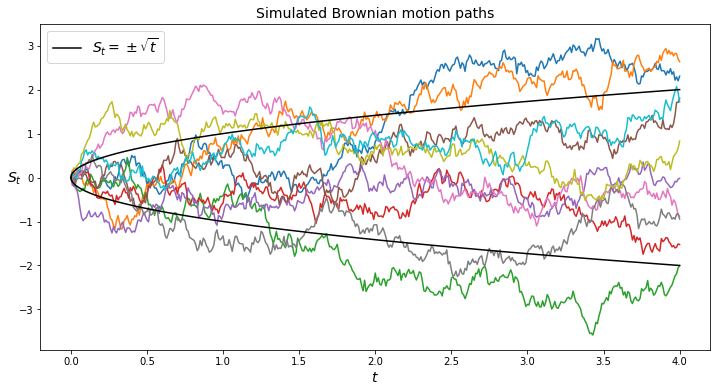

In [10]:
import math
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def Brownian_motion(mu, sigma, timesteps, T, N):
    # T = end time/maturity
    # N = number of sample functions generated
    
    dt = T/timesteps
    
    # random.normal takes standard deviation, not variance
    increments = np.random.normal(mu*dt, sigma*math.sqrt(dt), (timesteps, N))
    
    # linearly spaced columns from a row of zeros to a row of T's
    t = np.linspace(np.zeros(N), np.repeat(T, N), timesteps + 1)

    # add zeros as the first row to the sequences of partial sums of increments (columns)
    W = np.insert(np.cumsum(increments, axis = 0), 0, 0, axis = 0)
    
    return t, W

plt.figure(figsize = (12,6))
plt.title('Simulated Brownian motion paths', fontsize = 14)
plt.xlabel('$t$', fontsize = 14)
plt.ylabel('$S_t$', fontsize = 14, rotation = 0)

T = 4

plt.plot(*Brownian_motion(mu=0, sigma=1, timesteps=400, T=T, N=10))

t = np.linspace(0, T, 1000)
u_bound = np.sqrt(t)
l_bound = -np.sqrt(t)
plt.plot(t, u_bound, 'black', label='$S_t=\pm\sqrt{t}$')
plt.plot(t, l_bound, 'black')

plt.legend(fontsize = 14)
plt.show()

# Comparison to real stock data

Let us see how closely the S&P 500 followed a geometric Brownian motion model over the last 50 years.

In [2]:
import yfinance as yf
import datetime
from datetime import timedelta

stock = '^GSPC' # S&P 500
ticker = yf.Ticker(stock)
today = datetime.date.today()

stock_data = ticker.history(interval='1d', start=today-timedelta(days=50*365), end=today)
stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1974-02-27 00:00:00-04:00,0.0,97.430000,95.489998,96.400002,18730000,0.0,0.0
1974-02-28 00:00:00-04:00,0.0,96.980003,95.199997,96.220001,13680000,0.0,0.0
1974-03-01 00:00:00-04:00,0.0,96.400002,94.809998,95.529999,12880000,0.0,0.0
1974-03-04 00:00:00-04:00,0.0,95.949997,94.190002,95.529999,12270000,0.0,0.0
1974-03-05 00:00:00-04:00,0.0,98.169998,95.980003,97.320000,21980000,0.0,0.0


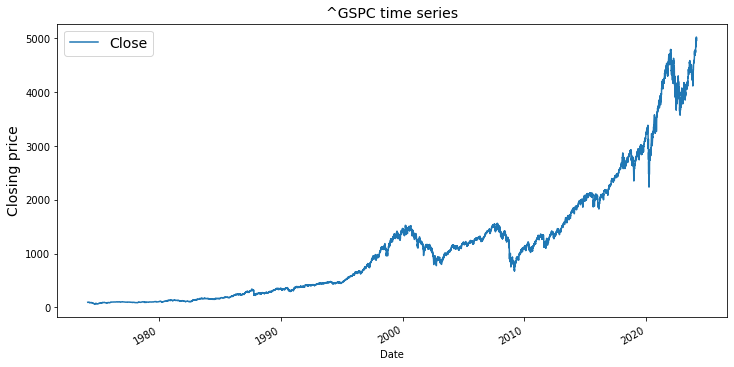

In [50]:
# closing prices
closing_data = stock_data['Close']
closing_data.plot(figsize = (12, 6))
plt.title(stock + ' time series', fontsize = 14)
plt.ylabel('Closing price', fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

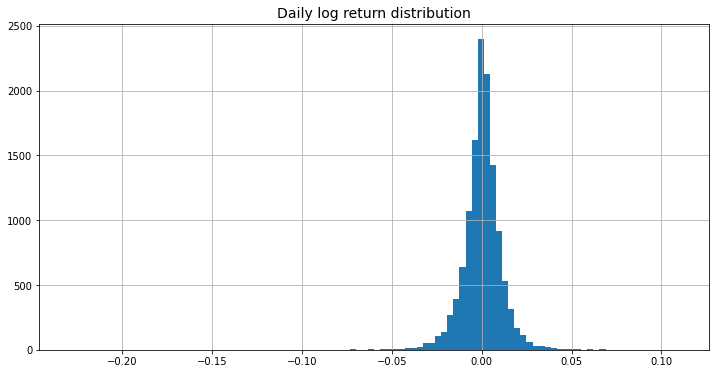

The annualised drift for ^GSPC is 7.897622%.
The anualised volatility for ^GSPC is 0.175882.


In [51]:
# log returns distribution
daily_returns = closing_data.pct_change() # percentage change, expressed as a decimal
daily_log_returns = np.log(daily_returns + 1)
daily_log_returns.hist(bins=100, figsize=(12, 6))
plt.title('Daily log return distribution', fontsize = 14)
plt.show()

# starting value
S0 = closing_data[0]

# annualised drift
drift = daily_log_returns.mean() * 252 # 252 trading days in a year
print('The annualised drift for {} is {:.6f}%.'.format(stock, drift*100))

# annualised volatility
volatility = daily_log_returns.std() * 252**0.5 # 252 trading days in a year
print('The anualised volatility for {} is {:.6f}.'.format(stock, volatility))

Is it obvious at a glance which of the following is the actual S&P 500 and which are the simulated processes?

In [45]:
# simulated paths with the same drift and volatility
t, X = Brownian_motion(mu=drift, sigma=volatility, timesteps=len(closing_data)-1, T=50, N=3)

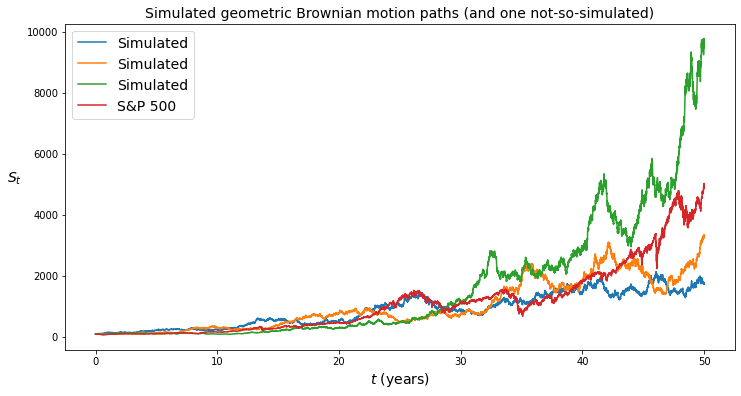

In [52]:
S = S0*np.exp(X)

plt.figure(figsize = (12,6))
plt.title('Simulated geometric Brownian motion paths (and one not-so-simulated)', fontsize = 14)
plt.xlabel('$t$ (years)', fontsize = 14)
plt.ylabel('$S_t$', fontsize = 14, rotation = 0, labelpad = 12)

plt.plot(t, S, label='Simulated')
plt.plot(t[:,0], closing_data, label='S&P 500')
# plt.plot(t, S0*np.exp(drift*t))

plt.legend(fontsize = 14)
plt.show()

# Testing the assumptions of the model

According to our model, the (joint) distribution of log returns should not change over time. This condition on time series data is called _stationarity_ and is oven checked in practice using the _Augmeted Dickey-Fuller_ test.

In [129]:
from statsmodels.tsa.stattools import adfuller

cleaned_log_returns = daily_log_returns.dropna() # remove any infinities of NaN'sb

p_value = adfuller(cleaned_log_returns, autolag="AIC")[1]

print('Augmeted Dickey-Fuller p-value [null hypothesis: unit root present (non-stationary)]: ', p_value)

Augmeted Dickey-Fuller p-value [null hypothesis: unit root present (non-stationary)]:  0.0


So the stationarity test is "passed" for now. What about if we used less data?

/Users/richardellard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  


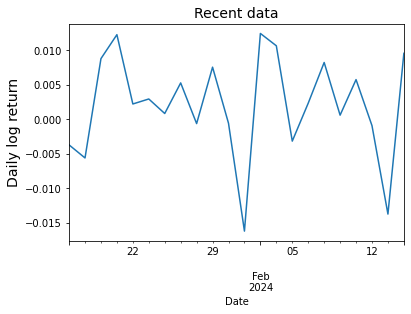

Augmeted Dickey-Fuller p-value from 2024-01-16 to 2024-02-15: 0.053459


In [57]:
one_month_ago = today-timedelta(days=30)
recent_data = cleaned_log_returns[one_month_ago:]

recent_data.plot()
plt.title('Recent data', fontsize = 14)
plt.ylabel('Daily log return', fontsize = 14)
plt.show()

p_value = adfuller(recent_data, autolag="AIC")[1]

print('Augmeted Dickey-Fuller p-value from {} to {}: {:.6f}'.format(one_month_ago, today, p_value))

It seems we are on the border of rejecting non-stationarity with the smaller dataset. Let's see if the daily log returns are correlated with previous daily log returns (lags).

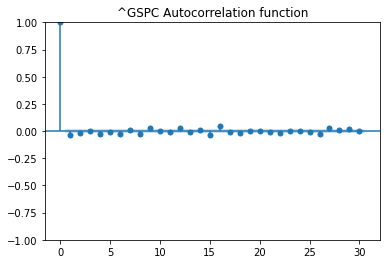

In [130]:
from statsmodels.graphics.tsaplots import plot_acf

pl = plot_acf(cleaned_log_returns, lags=30, title=stock+' Autocorrelation function')

It seems any correlations with past returns are tiny, but are any statistically significant?

In [134]:
from statsmodels.tsa.stattools import acf
import pandas as pd

autocorrelations, confidence_intervals = acf(cleaned_log_returns, nlags=30, alpha=0.05)

df = pd.DataFrame(confidence_intervals, columns = ['lower_bound', 'upper_bound'])
df.index.name = 'Lag'

df[~((df.lower_bound < 0) & (df.upper_bound > 0))]

,lower_bound,upper_bound
Lag,,
0,1.000000,1.000000
1,-0.049359,-0.014438
4,-0.043640,-0.008676
6,-0.040970,-0.005981
8,-0.042377,-0.007364
9,0.006966,0.042000
12,0.014554,0.049613
15,-0.050301,-0.015200
16,0.024876,0.060013


And on the reduced dataset:

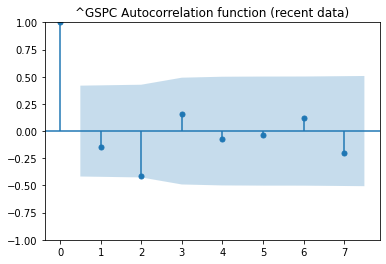

In [132]:
pl2 = plot_acf(recent_data, lags=7, title=stock+' Autocorrelation function (recent data)')